This Jupyter Notebook comprises of the following:
1. Dataset preparation for hurricane path and intensity prediction
2. Model Implementation for one window size and result visualisation

SECTION 1: Preparing the dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Final Datasets Hurricane Wise/Hurricane Ian for Model.xlsx')

In [3]:
df.head()

,ADVDATE,ADVISNUM,DATELBL,FLDATELBL,GUST,LAT,LON,MAXWIND,MSLP,SSNUM,TCDVLP,TAU,TCDIR,TCSPD,TIMEZONE,VALIDTIME
0,400 AM EDT Fri Sep 23 2022,1.0,5:00 AM Fri,2022-09-23 2:00 AM Fri AST,40,13.9,-68.6,30,1006,0,Tropical Depression,0,290,11,EDT,23/0600
1,400 AM EDT Fri Sep 23 2022,1.0,2:00 PM Fri,2022-09-23 2:00 PM Fri AST,45,14.4,-70.2,35,9999,0,Tropical Storm,12,9999,9999,EDT,23/1800
2,400 AM EDT Fri Sep 23 2022,1.0,2:00 AM Sat,2022-09-24 2:00 AM Sat AST,45,14.7,-72.6,35,9999,0,Tropical Storm,24,9999,9999,EDT,24/0600
3,400 AM EDT Fri Sep 23 2022,1.0,2:00 PM Sat,2022-09-24 2:00 PM Sat AST,45,14.8,-75.0,35,9999,0,Tropical Storm,36,9999,9999,EDT,24/1800
4,400 AM EDT Fri Sep 23 2022,1.0,2:00 AM Sun,2022-09-25 2:00 AM Sun AST,50,15.5,-77.1,40,9999,0,Tropical Storm,48,9999,9999,EDT,25/0600


In [46]:
import pandas as pd

columns = ['ADVDATE', 'ADVISNUM', 'GUST', 'LAT', 'LON', 'MAXWIND', 'MSLP', 'TAU']

# Function to calculate dW/dT and d2W/dT2
def calculate_dW_dT(group):
    # Sort by TAU to ensure the correct order
    group = group.sort_values(by='TAU')
    
    # Calculate dW/dT
    dW_dT = (group['MAXWIND'].diff() / group['TAU'].diff()).mean()
    
    # Calculate d2W/dT2
    dW_dT_diff = (group['MAXWIND'].diff() / group['TAU'].diff()).diff()
    d2W_dT2 = (dW_dT_diff / group['TAU'].diff()).mean()
    
    return dW_dT, d2W_dT2

# Group by ADVISNUM to process each advisory separately
transformed_data = []
for advisnum, group in df.groupby('ADVISNUM'):
    # Get the first row's LAT, LON, MSLP, W (MAXWIND)
    first_row = group.iloc[0]
    
    # Calculate WMAX (maximum MAXWIND in the advisory)
    WMAX = group['MAXWIND'].max()
    
    # Calculate dW/dT and d2W/dT2
    dW_dT, d2W_dT2 = calculate_dW_dT(group)
    
    # Append the transformed row
    transformed_data.append({
        'ADVISNUM': advisnum,
        'LAT': first_row['LAT'],
        'LON': first_row['LON'],
        'MSLP': first_row['MSLP'],
        'W': first_row['MAXWIND'],
        'dW/dT': dW_dT,
        'd2W/dT2': d2W_dT2,
        'WMAX': WMAX,
        'Timestamp': first_row['ADVDATE']
    })

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data)

# Output the transformed DataFrame
transformed_df


,ADVISNUM,LAT,LON,MSLP,W,dW/dT,d2W/dT2,WMAX,Timestamp
0,1.0,13.9,-68.6,1006,30,0.520833,0.001240,95,400 AM EDT Fri Sep 23 2022
1,2.0,14.2,-70.1,1006,30,0.598958,0.004960,100,1100 AM EDT Fri Sep 23 2022
2,3.0,14.7,-71.3,1006,30,0.625000,0.003720,100,500 PM EDT Fri Sep 23 2022
3,3.5,14.8,-71.5,1006,30,0.625000,0.003720,100,800 PM EDT Fri Sep 23 2022
4,4.0,14.8,-72.0,1005,35,0.598958,0.001240,100,1100 PM EDT Fri Sep 23 2022
...,...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,998,35,-0.625000,-0.034722,35,200 AM EDT Sat Oct 01 2022
64,35.0,35.7,-79.8,1001,30,-0.416667,NaN,30,500 AM EDT Sat Oct 01 2022
65,36.0,36.4,-79.9,1006,20,-0.208333,-0.034722,20,1100 AM EDT Sat Oct 01 2022
66,37.0,36.8,-78.8,1008,20,0.000000,NaN,20,500 PM EDT Sat Oct 01 2022


In [47]:
import pandas as pd

# Ensure ADVDATE is in datetime format
transformed_df['Timestamp'] = pd.to_datetime(transformed_df['Timestamp'], format='%I%M %p EDT %a %b %d %Y')

# Sort the dataframe by ADVISNUM and ADVDATE to ensure correct time order
transformed_df = transformed_df.sort_values(by=['ADVISNUM', 'Timestamp'])

# Display the updated dataframe with the Timestamp column
transformed_df[['ADVISNUM', 'Timestamp']]


,ADVISNUM,Timestamp
0,1.0,2022-09-23 04:00:00
1,2.0,2022-09-23 11:00:00
2,3.0,2022-09-23 17:00:00
3,3.5,2022-09-23 20:00:00
4,4.0,2022-09-23 23:00:00
...,...,...
63,34.5,2022-10-01 02:00:00
64,35.0,2022-10-01 05:00:00
65,36.0,2022-10-01 11:00:00
66,37.0,2022-10-01 17:00:00


In [48]:
# CONVERTING TIMESTAMP TO TIMEELAPSED
start_time = transformed_df['Timestamp'].iloc[0]
time_elapsed = []
# Loop through each row and calculate the time difference in hours
for Timestamp in transformed_df['Timestamp']:
    elapsed = (Timestamp - start_time).total_seconds() / 3600  # Convert seconds to hours
    time_elapsed.append(elapsed)

# Add the TimeElapsed column to the DataFrame
transformed_df['TimeElapsed'] = time_elapsed
transformed_df

,ADVISNUM,LAT,LON,MSLP,W,dW/dT,d2W/dT2,WMAX,Timestamp,TimeElapsed
0,1.0,13.9,-68.6,1006,30,0.520833,0.001240,95,2022-09-23 04:00:00,0.0
1,2.0,14.2,-70.1,1006,30,0.598958,0.004960,100,2022-09-23 11:00:00,7.0
2,3.0,14.7,-71.3,1006,30,0.625000,0.003720,100,2022-09-23 17:00:00,13.0
3,3.5,14.8,-71.5,1006,30,0.625000,0.003720,100,2022-09-23 20:00:00,16.0
4,4.0,14.8,-72.0,1005,35,0.598958,0.001240,100,2022-09-23 23:00:00,19.0
...,...,...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,998,35,-0.625000,-0.034722,35,2022-10-01 02:00:00,190.0
64,35.0,35.7,-79.8,1001,30,-0.416667,NaN,30,2022-10-01 05:00:00,193.0
65,36.0,36.4,-79.9,1006,20,-0.208333,-0.034722,20,2022-10-01 11:00:00,199.0
66,37.0,36.8,-78.8,1008,20,0.000000,NaN,20,2022-10-01 17:00:00,205.0


In [49]:
df_final = transformed_df[['ADVISNUM','LAT','LON','MSLP','W','dW/dT','WMAX','TimeElapsed']]
df_final

,ADVISNUM,LAT,LON,MSLP,W,dW/dT,WMAX,TimeElapsed
0,1.0,13.9,-68.6,1006,30,0.520833,95,0.0
1,2.0,14.2,-70.1,1006,30,0.598958,100,7.0
2,3.0,14.7,-71.3,1006,30,0.625000,100,13.0
3,3.5,14.8,-71.5,1006,30,0.625000,100,16.0
4,4.0,14.8,-72.0,1005,35,0.598958,100,19.0
...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,998,35,-0.625000,35,190.0
64,35.0,35.7,-79.8,1001,30,-0.416667,30,193.0
65,36.0,36.4,-79.9,1006,20,-0.208333,20,199.0
66,37.0,36.8,-78.8,1008,20,0.000000,20,205.0


SECTION 2: Model Implementation Begins

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [9]:
# Select features to use
features = ['LAT', 'LON', 'MSLP', 'W', 'dW/dT', 'WMAX', 'TimeElapsed']
df_final = df_final[features]

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_final)

In [33]:
# Prepare data for sliding window approach
def create_dataset(data, time_step=3):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])  # Predicting the entire row for the next time step
    return np.array(X), np.array(y)

time_step = 3
X, y = create_dataset(data_scaled, time_step)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features)))  # Output layer should match number of features (7)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to get the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

Epoch 1/500


C:\Users\Mridul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.3031 - val_loss: 0.3505
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2612 - val_loss: 0.3165
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2284 - val_loss: 0.2847
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1948 - val_loss: 0.2548
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1655 - val_loss: 0.2267
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1338 - val_loss: 0.2007
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1089 - val_loss: 0.1772
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0876 - val_loss: 0.1573
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0673 - val_loss: 0.1420
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0529 - val_loss: 0.1323
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0417 - val_loss: 0.1298
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0366 - val_loss: 0.1335


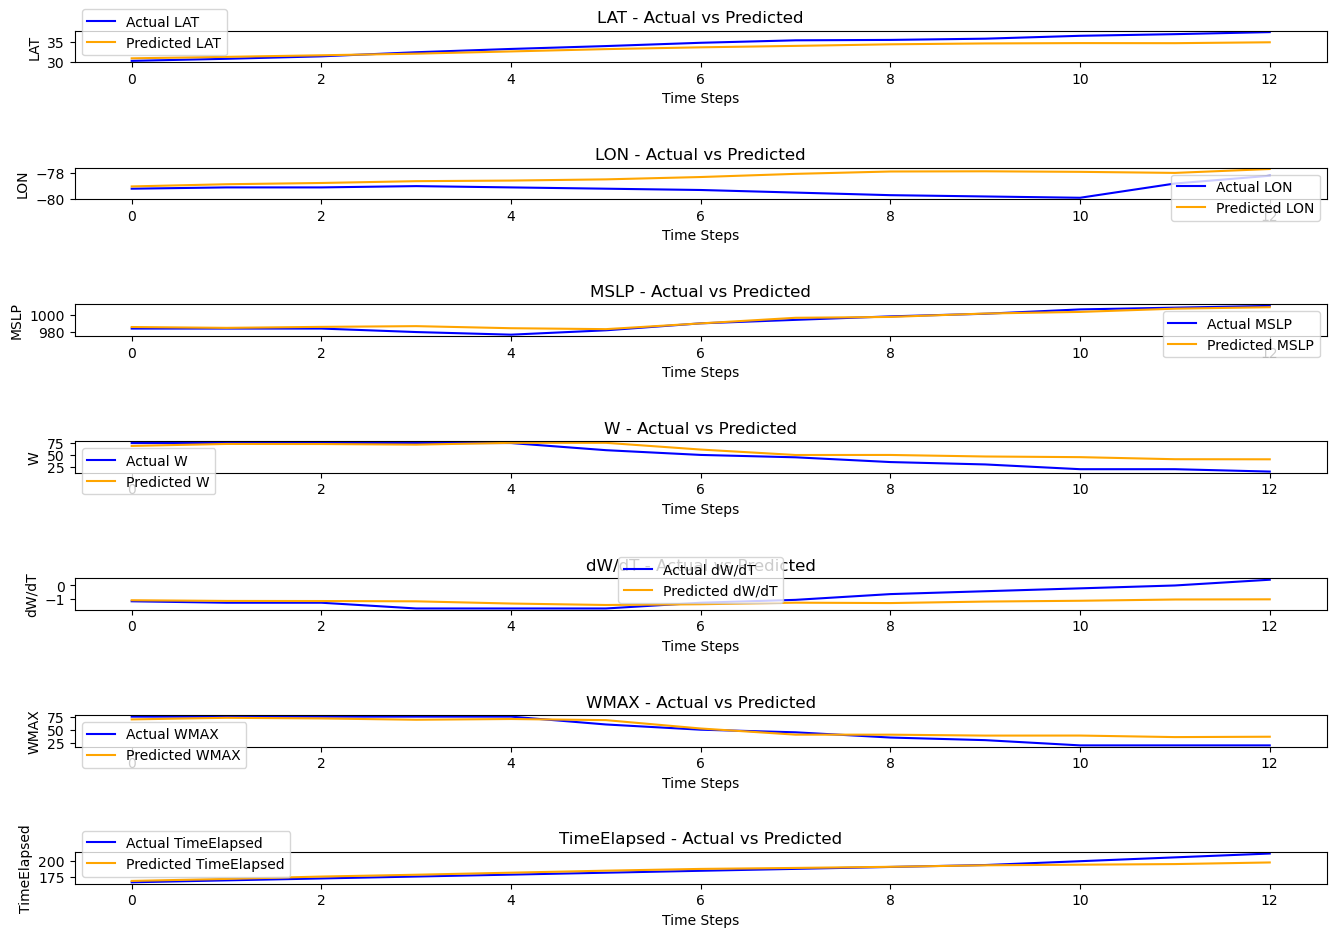

In [34]:
# Plot the error (predicted vs actual) for each feature
plt.figure(figsize=(14, 10))  # Increase the overall figure size
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(y_test_rescaled[:, i], label='Actual ' + feature, color='blue')
    plt.plot(y_pred_rescaled[:, i], label='Predicted ' + feature, color='orange')
    plt.title(f'{feature} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel(feature)
    plt.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)  # Increase padding to make space between plots
plt.show()

Looking at the Mean Absolute Error for each feature

In [35]:
# Calculate and print the error for each feature
error = np.abs(y_pred_rescaled - y_test_rescaled)
for i, feature in enumerate(features):
    print(f'Mean Absolute Error for {feature}: {np.mean(error[:, i])}')

Mean Absolute Error for LAT: 1.0911216442401588
Mean Absolute Error for LON: 0.9199012169471147
Mean Absolute Error for MSLP: 2.229205791766818
Mean Absolute Error for W: 11.4795775780311
Mean Absolute Error for dW/dT: 0.5005340178807577
Mean Absolute Error for WMAX: 7.852262643667368
Mean Absolute Error for TimeElapsed: 3.950182401216945


Looking at the correlation heatmap of features to verify if feature engineering is helpful

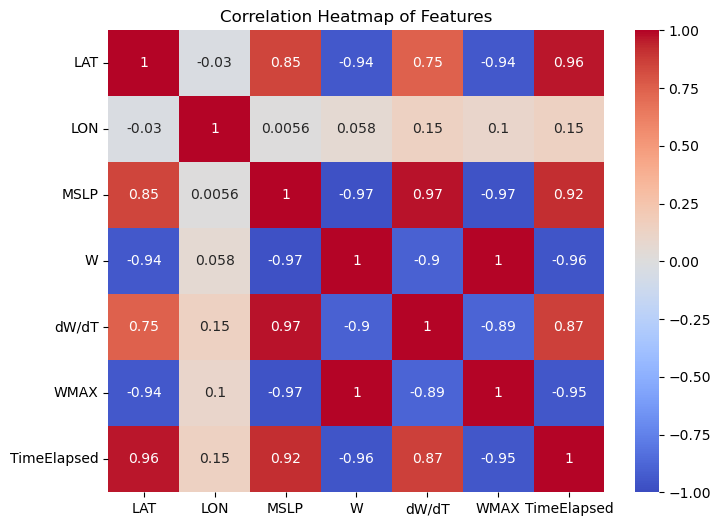

In [37]:
import seaborn as sns
corr_matrix = pd.DataFrame(y_test_rescaled, columns=features).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()


We can clearly see that for WMAX, almost all features hold a good relation

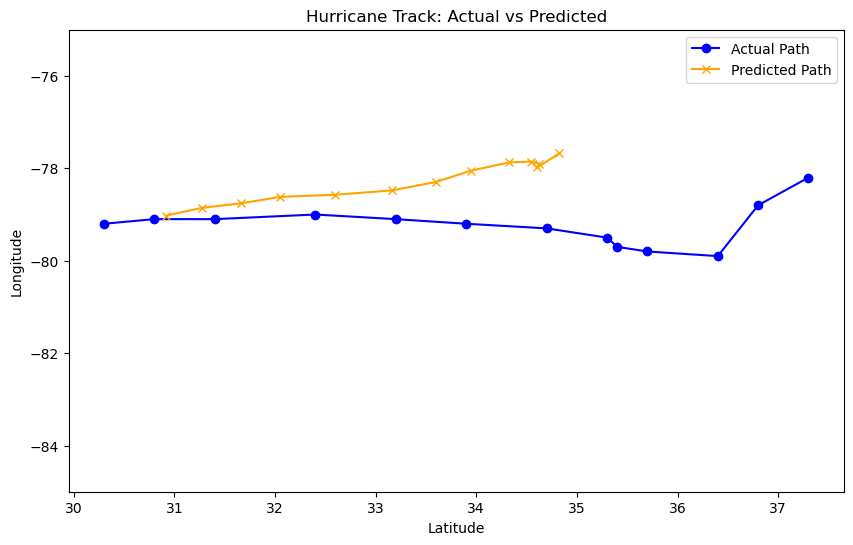

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:, 0], y_test_rescaled[:, 1], label='Actual Path', marker='o', color='blue')
plt.plot(y_pred_rescaled[:, 0], y_pred_rescaled[:, 1], label='Predicted Path', marker='x', color='orange')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hurricane Track: Actual vs Predicted')
plt.ylim(-85,-75)
plt.legend()
plt.show()

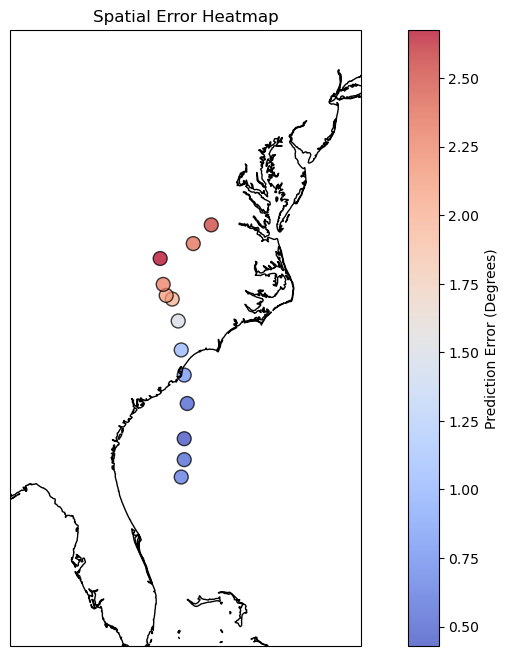

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

sc = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Prediction Error (Degrees)')
plt.title('Spatial Error Heatmap')
plt.show()


Plotting the Actual vs Predicted paths on a map, where the actual path is colored by error

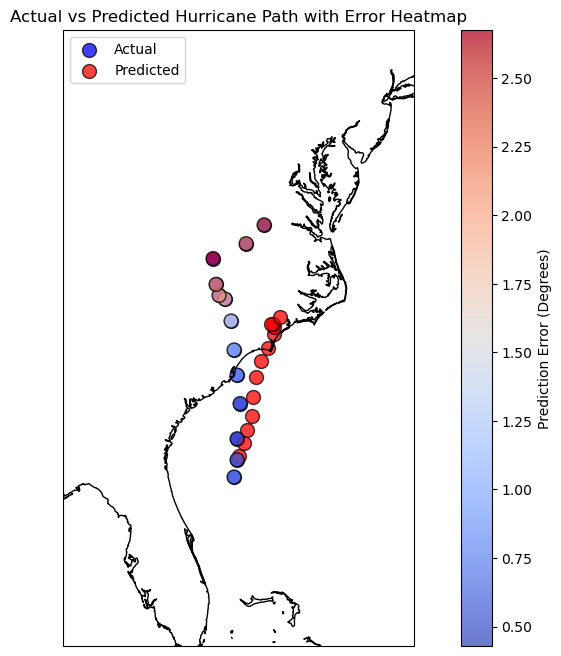

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns for both actual and predicted data
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

# Scatter plot for actual points
sc_actual = ax.scatter(lon_actual, lat_actual, c='blue', label='Actual', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Scatter plot for predicted points
sc_pred = ax.scatter(lon_pred, lat_pred, c='red', label='Predicted', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Add colorbar for error magnitude
sc_error = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc_error, label='Prediction Error (Degrees)')

# Add a legend
plt.legend(loc='upper left')

plt.title('Actual vs Predicted Hurricane Path with Error Heatmap')
plt.show()


Creating an intensity classification function to understand how intensity predictions are performing

In [41]:
def classify_intensity_knots(WMAX, MSLP, dW_dT):
    if WMAX >= 96 or (MSLP < 945 and dW_dT > 2.5):  # Major Hurricane conditions
        return 'Major Hurricane'
    elif WMAX >= 64 or (MSLP < 980 and dW_dT > 1.5):  # Hurricane conditions
        return 'Hurricane'
    elif WMAX >= 34:  # Tropical Storm threshold
        return 'Tropical Storm'
    else:
        return 'Tropical Depression'

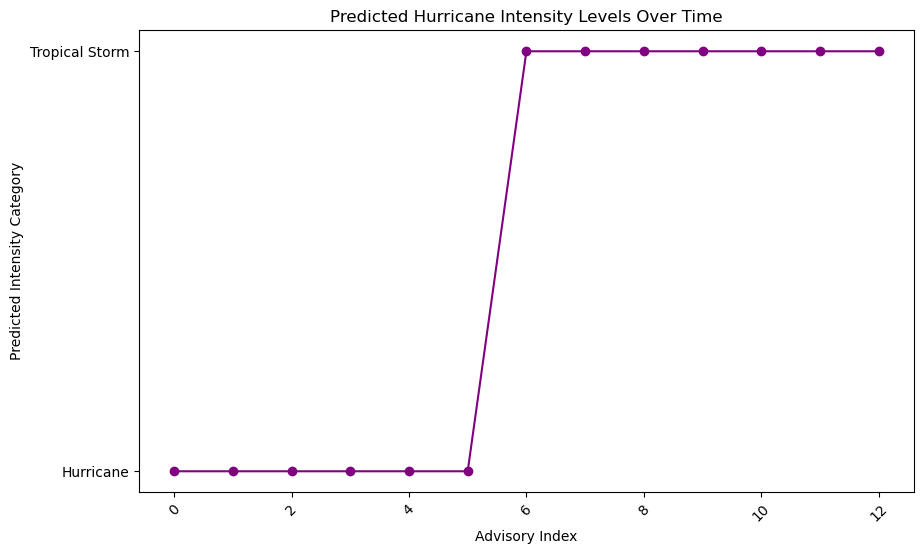

In [42]:
intensity_levels = [classify_intensity_knots(wmax, mslp, dwdt) 
                    for wmax, mslp, dwdt in zip(y_pred_rescaled[:, features.index('WMAX')], 
                                                y_pred_rescaled[:, features.index('MSLP')],
                                                y_pred_rescaled[:, features.index('dW/dT')])]

plt.figure(figsize=(10, 6))
plt.plot(range(len(intensity_levels)), intensity_levels, marker='o', linestyle='-', color='purple')
plt.xticks(rotation=45)
plt.xlabel("Advisory Index")
plt.ylabel("Predicted Intensity Category")
plt.title("Predicted Hurricane Intensity Levels Over Time")
plt.show()

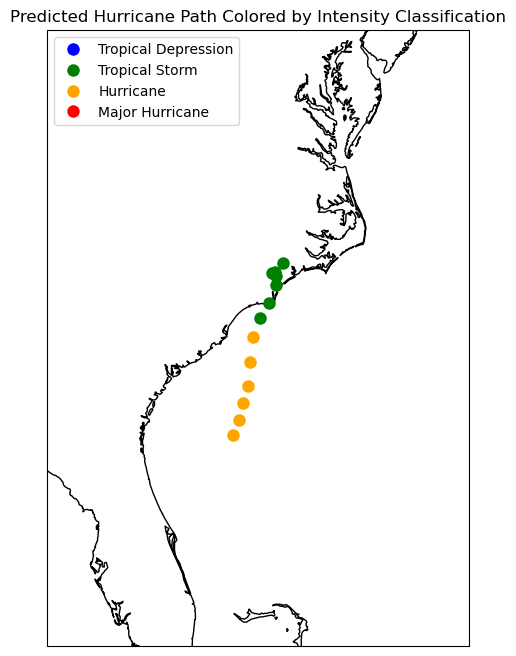

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.colors as mcolors

# Convert intensity levels to color codes
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Map each advisory to a color based on intensity classification
colors = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_pred) - 5, max(lon_pred) + 5, min(lat_pred) - 5, max(lat_pred) + 5])

# Plot the predicted path, coloring points by intensity classification
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='o', color=colors[i], markersize=8,
            transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
plt.legend(handles=handles, loc='upper left')

plt.title("Predicted Hurricane Path Colored by Intensity Classification")
plt.show()


Intensity as well as path plotted on a map for Actual vs Prediction data

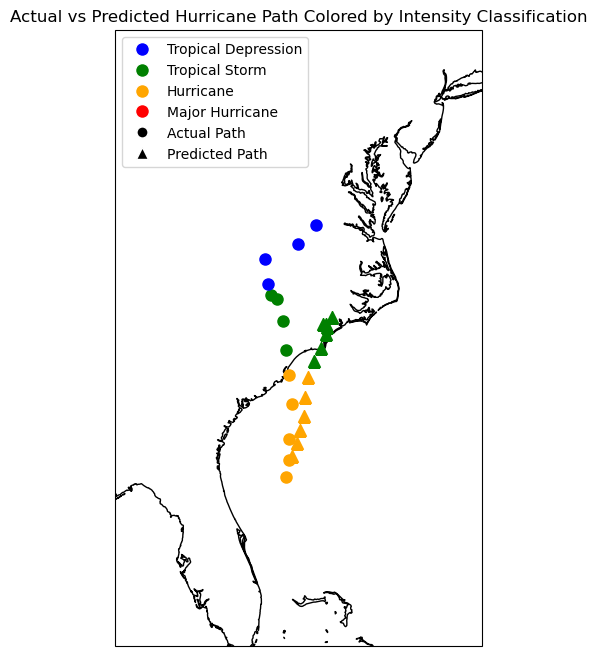

In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming the classify_intensity_knots function is already defined

# Calculate intensity classifications for actual data
intensity_levels_actual = [classify_intensity_knots(wmax, mslp, dwdt) 
                           for wmax, mslp, dwdt in zip(y_test_rescaled[:, features.index('WMAX')], 
                                                       y_test_rescaled[:, features.index('MSLP')],
                                                       y_test_rescaled[:, features.index('dW/dT')])]

# Map intensity levels to colors for both predicted and actual data
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Color lists for actual and predicted paths
colors_actual = [intensity_colors[level] for level in intensity_levels_actual]
colors_predicted = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(min(lon_actual), min(lon_pred)) - 5, max(max(lon_actual), max(lon_pred)) + 5, 
               min(min(lat_actual), min(lat_pred)) - 5, max(max(lat_actual), max(lat_pred)) + 5])

# Plot actual path with colors for intensity
for i in range(len(lon_actual)):
    ax.plot(lon_actual[i], lat_actual[i], marker='o', color=colors_actual[i], markersize=8, 
            label='Actual' if i == 0 else "", transform=ccrs.PlateCarree())

# Plot predicted path with colors for intensity
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='^', color=colors_predicted[i], markersize=8, 
            label='Predicted' if i == 0 else "", transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label="Actual Path", markerfacecolor='k', markersize=8))
handles.append(plt.Line2D([0], [0], marker='^', color='w', label="Predicted Path", markerfacecolor='k', markersize=8))
plt.legend(handles=handles, loc='upper left')

plt.title("Actual vs Predicted Hurricane Path Colored by Intensity Classification")
plt.show()


Thus we conclude this notebook.
1. We need better features - leads us to Approach B
2. Implement the model for different window sizes to compare results
3. We need to verify if the intensity classification function is accurate - also check after implementing on better features